These Models Classifies images of concrete as Cracked (Positive) or Not Cracked (Negative).

The dataset is 20,000 even class split data of 227x227 RGB jpgs.

This is useful for infrastructure because Drones can be utilized to image the roads, sidewalks, train tracks around the world.

Can create more sophisticated models that optimize infrastructure maintenance spending and prevent accidents caused by undetected failing materials.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv

from google.colab import drive
drive.mount('/content/drive/')
from glob import glob
from google.colab.patches import cv2_imshow

#First Load Picture Samples
NegativeSet = glob('drive/My Drive/ML-Negative/NegativeFull/*.jpg')
PositiveSet = glob('drive/My Drive/ML-Positive/PositiveFull/*.jpg')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Text(0.5, 1.0, 'Cracked')

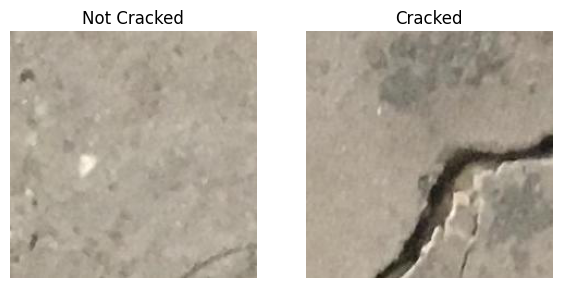

In [3]:
#Here is an example of Cracked and Not Cracked Concrete Images from the dataset
NotCracked = plt.imread(NegativeSet[5])
Cracked = plt.imread(PositiveSet[5])
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].imshow(NotCracked)
axs[1].imshow(Cracked)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('Not Cracked')
axs[1].set_title('Cracked')

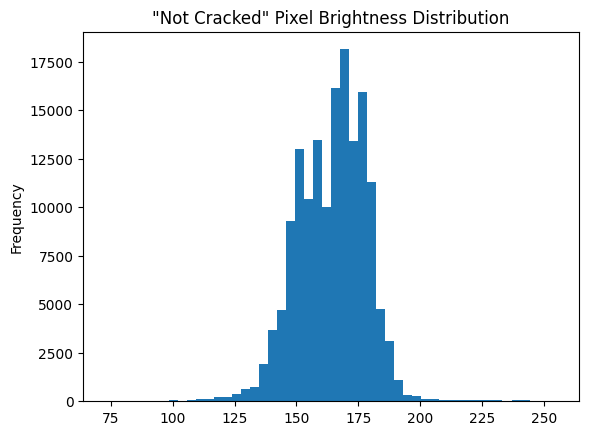

<Axes: title={'center': '"Cracked" Pixel Brightness Distribution'}, ylabel='Frequency'>

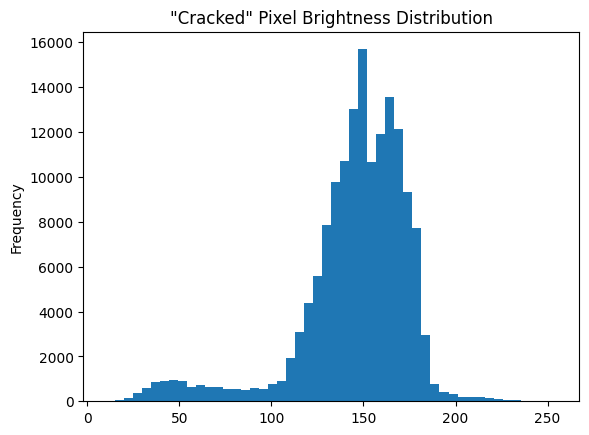

In [4]:
#Visualization of 2 Sample image data
pd.Series(NotCracked.flatten()).plot(kind='hist',
                                     bins=50,
                                     title='"Not Cracked" Pixel Brightness Distribution')
plt.show()
pd.Series(Cracked.flatten()).plot(kind='hist',
                                         bins=50,
                                         title='"Cracked" Pixel Brightness Distribution')


Cracked picture Sample has long tail for darker shadow pixels that is much lower than overall distribution. Need to find model to train this information to.

No need to average the distributions of all photos, the trend is clear.

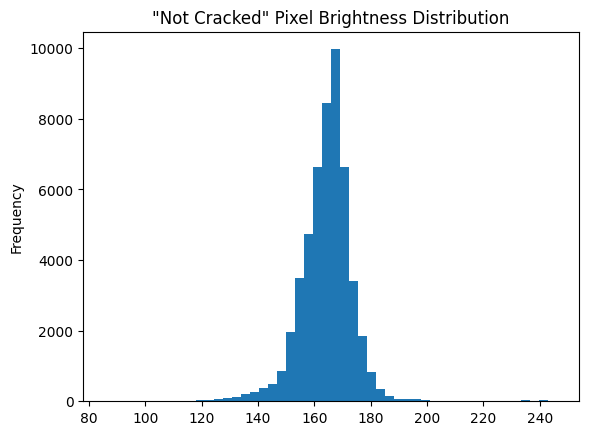

<Axes: title={'center': '"Cracked" Pixel Brightness Distribution'}, ylabel='Frequency'>

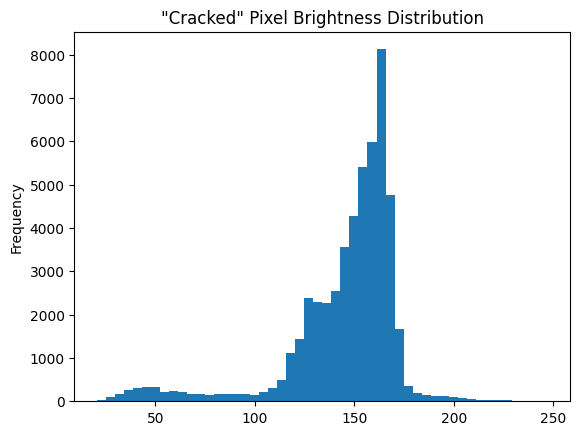

In [5]:
#Check RGB dimension to see if necessary..
NotCrackedAvg = np.mean(NotCracked, axis=2)
CrackedAvg = np.mean(Cracked, axis= 2)
pd.Series(NotCrackedAvg.flatten()).plot(kind='hist',
                                     bins=50,
                                     title='"Not Cracked" Pixel Brightness Distribution')
plt.show()
pd.Series(CrackedAvg.flatten()).plot(kind='hist',
                                         bins=50,
                                         title='"Cracked" Pixel Brightness Distribution')

2D Pictures are showing same trend, only need Grayscale for the models.


Text(0.5, 1.0, 'Cracked Gray')

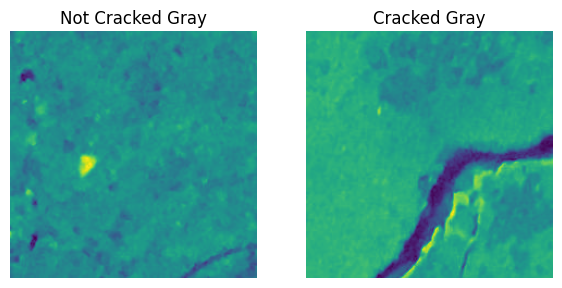

In [6]:
#New Grayscale pictures to see
#NotCrackedAvg = cv.resize(NotCrackedAvg, (50,50))
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].imshow(NotCrackedAvg)
axs[1].imshow(CrackedAvg)
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('Not Cracked Gray')
axs[1].set_title('Cracked Gray')

New Images look different but still have the key features for crack detection.

In [7]:
#Dstack Pictures to make rectangular prism 3D matrix
x = plt.imread(NegativeSet[0])
NegImg = np.mean(x, axis =2)
NegImg = np.expand_dims(NegImg, axis =2)

for i in range(1, 101):
    xi = plt.imread(NegativeSet[i])
    xi2 = np.mean(xi,axis =2)
    xi3 = np.expand_dims(xi2, axis =2)
    NegImg= np.dstack([NegImg, xi3])

x = plt.imread(PositiveSet[0])
PosImg = np.mean(x, axis =2)
PosImg = np.expand_dims(PosImg, axis =2)

for i in range(1, 101):
    xi = plt.imread(PositiveSet[i])
    xi2 = np.mean(xi,axis =2)
    xi3 = np.expand_dims(xi2, axis =2)
    PosImg= np.dstack([PosImg, xi3])

NegImg = NegImg / 255
PosImg = PosImg / 255
ComboImg = np.dstack([NegImg, PosImg])

np.shape(ComboImg)
#This 3 Dimensional Matrix is not useful shape for models... I will retry with flattened data in next slide.

(227, 227, 202)

In [8]:
np.shape(ComboImg)

(227, 227, 202)

This 3 Dimensional Matrix is maybe not a useful shape for models... Nowhere to put class label, and i do not think Train Test split accepts this shape of data. I will retry with flattened data in next slide.

Vstack data Instead... I will blur them because they are too much data, and flatten them so they fit in 2D Matrix.

Each row will be a separate picture and one class label.

In [9]:
#Preprocess Negative (No Crack) Images
x = plt.imread(NegativeSet[0])
FlatNegImg = np.mean(x, axis =2) #Grayscale
FlatNegImg = cv.resize(FlatNegImg,(50,50))
FlatNegImg = FlatNegImg.flatten()
FlatNegImg = np.expand_dims(FlatNegImg, axis =1)

#Number of images and class labels 'Negative' = 0
nN = 200
NLabels = np.zeros(nN)

for i in range(1, nN):
    xi = plt.imread(NegativeSet[i])
    xi2 = np.mean(xi,axis =2) #Grayscale
    xi3 = cv.resize(xi2,(50,50))
    xi4 = xi3.flatten()
    xi5 = np.expand_dims(xi4, axis =1)
    FlatNegImg= np.hstack([FlatNegImg, xi5])

# Preprocess positive (crack) Images
x = plt.imread(PositiveSet[0])
FlatPosImg = np.mean(x, axis =2) #Grayscale
FlatPosImg = cv.resize(FlatPosImg,(50,50))
FlatPosImg = FlatPosImg.flatten()
FlatPosImg = np.expand_dims(FlatPosImg, axis =1)

#Number of images and class labels 'Positive' = 1
nP = 200
PLabels = np.ones(nP)

for i in range(1, nP):
    xi = plt.imread(PositiveSet[i])
    xi2 = np.mean(xi,axis =2) #Grayscale
    xi3 = cv.resize(xi2,(50,50))
    xi4 = xi3.flatten()
    xi5 = np.expand_dims(xi4, axis =1)
    FlatPosImg= np.hstack([FlatPosImg, xi5])

#Combine positive and negative Data and Labels.
FlatComboImg = np.transpose(np.hstack([FlatNegImg, FlatPosImg])) #This is aka X 'data' matrix
ComboClasses = np.hstack([NLabels, PLabels]) #This is aka y 'class labels' column


First Model is a KNearest Neighbors model using all 50x50 pixels.

In [10]:
#Create Train Test split
print(np.shape(FlatComboImg))
print(np.shape(ComboClasses))
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = \
  train_test_split(FlatComboImg, ComboClasses,
                   test_size=0.2,
                   stratify=ComboClasses,
                   random_state=39)

#Try Different Models/ KNN first, manually optmized number of neighbors to 3 by guessing 1-10.
KNN = KNeighborsClassifier(n_neighbors=3,
                              p=2,
                              metric='minkowski')

KNNpipe = make_pipeline(StandardScaler(), KNN)

#score = cross_val_score(estimator=KNNpipe,
                         #X=X_train,
                         #y=Y_train,
                         #cv=10,
                         #n_jobs=1)

Fit = KNNpipe.fit(X_train, Y_train)
y_pred = Fit.predict(X_test)
test_acc = Fit.score(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')

# Model was not working well. Too much random pixel brightness noise included. Most of pixel brightnesses do not matter, only the outliers really.
# Only ~55% accuracy, not much better than random guess.

(400, 2500)
(400,)
Test accuracy: 0.550


This model is not accurate, only ~55% accuracy. Too much random pixel brightness noise included.

Most of pixel brightnesses do not matter, only the outliers really.


Now lets test narrowed down feature space by using possible outliers, Max, Min.

In [11]:
One = np.mean(FlatComboImg, axis=1)
two = np.median(FlatComboImg, axis=1)
three = np.amin(FlatComboImg, axis=1)
four = np.amax(FlatComboImg, axis=1)
#Mean and median hurt model performance, so excluded from training set, only need outliers.
FourFeatComboImg = np.transpose(np.vstack((three, four)))
print(np.shape(FourFeatComboImg))

X_train, X_test, Y_train, Y_test = \
  train_test_split(FourFeatComboImg, ComboClasses,
                   test_size=0.2,
                   stratify=ComboClasses,
                   random_state=39)

Fit = KNNpipe.fit(X_train, Y_train)
y_pred = Fit.predict(X_test)
test_acc = Fit.score(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')

#This is very accurate. But is somewhat of a trick and is not really crack recognition per se... more of a contrast recognizer.
#resizing photos to (50,50) is important because it fixes oulier noise like a single black pixel from fooling model.

(400, 2)
Test accuracy: 0.988


This is very accurate, 99%. But is a trick and is not really crack recognition, it is a contrast recognizer.

Resizing photos to (50,50) is important because it fixes oulier noise like a single black pixel from fooling model.

In [12]:
#Create MLP train test sets
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
train = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)

#Will not mix train and test data in these folders.
trainset = train.flow_from_directory('drive/My Drive/Concrete',
                                     target_size = (50,50),
                                     batch_size = 10,
                                     class_mode = 'binary')
valset = validation.flow_from_directory('drive/My Drive/ConcreteVal',
                                        target_size = (50,50),
                                        batch_size = 10,
                                        class_mode = 'binary')
trainset.class_indices
valset.class_indices

Found 1168 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


{'Crack': 0, 'No Crack': 1}

Convolutional Neural Networks are good at image recognition, lets try it.

In [13]:
# Initialize Convolutional MLP model
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape = (50,50,3)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(32,(3,3),activation= 'relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation= 'relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])
model.compile(loss= 'binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [14]:
model.fit(trainset,
          epochs = 5,
          validation_data=valset)


Epoch 1/5
117/117 [==============================] - 222s 2s/step - loss: 0.7636 - accuracy: 0.5437 - val_loss: 0.6609 - val_accuracy: 0.9545
Epoch 2/5
117/117 [==============================] - 9s 80ms/step - loss: 0.2621 - accuracy: 0.9041 - val_loss: 0.1485 - val_accuracy: 0.9591
Epoch 3/5
117/117 [==============================] - 13s 112ms/step - loss: 0.1092 - accuracy: 0.9606 - val_loss: 0.0636 - val_accuracy: 1.0000
Epoch 4/5
117/117 [==============================] - 10s 84ms/step - loss: 0.0912 - accuracy: 0.9743 - val_loss: 0.0936 - val_accuracy: 0.9955
Epoch 5/5
117/117 [==============================] - 9s 77ms/step - loss: 0.0760 - accuracy: 0.9812 - val_loss: 0.0423 - val_accuracy: 0.9909


The CNN is most accurate. Has larger testing set and achieved validation accuracy of >99.5% in few epochs.

In [15]:
from sklearn.ensemble import RandomForestClassifier

RFCmod = RandomForestClassifier(random_state=3)

RFCfit = RFCmod.fit(X_train, Y_train)

RFCpred = RFCfit.predict(X_test)

RFCCV = cross_val_score(estimator=RFCfit,
                         X=X_train,
                         y=Y_train,
                         cv=10,
                         n_jobs=1)
#Find incorrectly classified pictures
for idx, x in enumerate(Y_test):
    if x != RFCpred[idx]:
          print(idx, x)
print(RFCCV)

RFCscore = RFCfit.score(X_test, Y_test)
print(RFCscore)

60 0.0
[1.      1.      1.      0.9375  0.96875 1.      1.      0.96875 1.
 0.96875]
0.9875


Random Forest classsifier scores similar to KNN at 98.8% , misclassifies photo #60.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

Logi = LogisticRegression(penalty='l2',
                          solver='lbfgs',
                          random_state=3)
LogiMod = make_pipeline(StandardScaler(),
                        LogisticRegression())
LogiFit = LogiMod.fit(X_train, Y_train)

LogiPred = LogiFit.predict(X_test)

LogiCV = cross_val_score(estimator=LogiFit,
                         X=X_train,
                         y=Y_train,
                         cv=10,
                         n_jobs=1)

for idx, x in enumerate(Y_test):
    if x != LogiPred[idx]:
          print(idx, x)

print(LogiCV)
LogiScore = LogiFit.score(X_test, Y_test)
print(LogiScore)


60 0.0
[0.96875 1.      1.      0.9375  0.96875 0.96875 1.      0.96875 1.
 0.96875]
0.9875


Logistic Regression model also misclassifies photo #60

Conclusion

**KNN, RFC, LogisticRegression have good performance ~98.8% for test set, all seem to missclassify the same photo #60 in test set. **

RFC has most accurate training CV due to many 1.0 in CV vector.

This is probably due to very small crack (small amount of dim pixel outlier). For real life application this is less important than classifying the severely cracked concrete, which may be close to failure.


**The Convolutional Neural network has the best performace, 99.6% but also has larger test set and different training data.**

This model is superior to others in terms of accuracy and adaptability, due to its ability to recognize cracks in entire photo rather than
only contrast differences.


**The Simpler models may be good enough with small changes to use for the drone with high resolution camera.**

***For future models:***
Perhaps could code some function that will exaggerate contrast differences in the data. There is other ML work to be done in terms of training
the drone how to take up close pictures without including things like grass, or yellow lines on road, etc.